<a href="https://colab.research.google.com/github/Saibot19/7506R-1C2023-GRUPO21/blob/main/7506R_TP1_GRUPO21_CHP2_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arboles


## Importaciones



In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from google.colab import drive


#modelos y métricas
import sklearn as sk
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
#preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.tree import export_text


drive.mount('/content/drive', force_remount=True)
df_trabajo = pd.read_csv("/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Datasets/hotels_train_filtered.csv")
df_test = pd.read_csv("/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Datasets/hotels_test.csv")

df_trabajo

Mounted at /content/drive


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,id,is_canceled,agent_cancela_seguido,habitacion_correcta,estadia
0,City Hotel,49,2016,September,37,5,1,2,1,0.0,...,0,Transient,115.50,0,1,7aa4cc6b-b92c-4061-b21d-4f9e0cac4689,1,False,True,Reserva con\nambos casos
1,Resort Hotel,4,2015,October,44,31,0,1,2,0.0,...,0,Transient,42.00,1,0,b1428f80-c56c-4ae4-91a9-6962edae08b1,0,False,True,Reservas entre\nsemana
2,City Hotel,25,2016,October,42,13,0,1,2,2.0,...,0,Transient,229.00,0,2,2226c018-ea20-4c4e-8f71-ea66aee70d7c,0,False,True,Reservas entre\nsemana
3,City Hotel,26,2016,December,51,12,2,5,2,0.0,...,0,Transient,75.00,0,0,314f56dc-2e4d-4298-9bdd-27bb008bffff,1,True,True,Reserva con\nambos casos
4,City Hotel,104,2017,March,12,19,2,5,2,0.0,...,0,Transient-Party,75.00,0,1,28c75445-c603-413a-babf-ad377018b592,0,True,True,Reserva con\nambos casos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60627,Resort Hotel,24,2017,January,4,27,0,2,2,0.0,...,0,Transient,48.00,0,1,32bffef5-5404-4e86-9f39-fd2282e1ad7f,1,False,False,Reservas entre\nsemana
60628,City Hotel,0,2016,September,36,2,0,1,1,0.0,...,0,Transient,149.00,0,0,cc922a1c-356e-42a5-a984-0b1af03c2f5c,0,False,True,Reservas entre\nsemana
60629,City Hotel,10,2017,May,19,8,1,2,1,0.0,...,0,Transient,95.00,0,0,76fb0e83-59df-43ee-9c33-aec51030ed45,0,False,True,Reserva con\nambos casos
60630,Resort Hotel,143,2015,October,41,10,2,5,2,0.0,...,0,Transient,36.05,0,0,01906859-1094-4e37-b13e-b015b594d159,1,False,True,Reserva con\nambos casos


## Seteo para la evaluacion


- Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold
Cross Validation para obtener la mejor performance. ¿Cuántos folds utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

- Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.
- Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y decisiones evaluadas (explicar las primeras reglas obtenidas).
- Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.
- Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

In [ ]:
#df_trabajo.drop(['children','babies','meal'], axis='columns',inplace=True)


In [16]:
df_trabajo['is_canceled'].value_counts(normalize=True)*100

1    50.216058
0    49.783942
Name: is_canceled, dtype: float64

### Label Enonder

In [17]:
df_trabajo_x_LE = df_trabajo.drop(['is_canceled','id'], axis='columns')
df_trabajo_y = df_trabajo['is_canceled'].copy()

In [18]:
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in df_trabajo_x_LE.columns:
    if df_trabajo_x_LE[column].dtype == 'object':
        df_trabajo_x_LE[column] = le.fit_transform(df_trabajo_x_LE[column])

In [19]:
#Separo un set de Evaluacion

x_train_LE, x_test_LE, y_train_LE, y_test_LE = train_test_split(df_trabajo_x_LE, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_LE)))
print('# Datos Prueba: {}'.format(len(x_test_LE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_LE,y_test_LE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


### One hot encoding

In [20]:
df_trabajo_x_OHE = df_trabajo.drop(['is_canceled','id'], axis='columns')

In [21]:

df_trabajo_x_OHE = pd.get_dummies(df_trabajo_x_OHE, columns=['hotel','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)
#df_trabajo_x_OHE = pd.get_dummies(df_trabajo_x_OHE, columns=['country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)

# Hay un par de variables que no consideramos que sea mejor con OHE como los mese que ya tienen un orden o meal que solo creemos que va agregar ruido
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in df_trabajo_x_OHE.columns:
    if df_trabajo_x_OHE[column].dtype == 'object':
        df_trabajo_x_OHE[column] = le.fit_transform(df_trabajo_x_OHE[column])

In [22]:
len(df_trabajo_x_OHE.columns.to_list())

63

In [23]:
x_train_OHE, x_test_OHE, y_train_OHE, y_test_OHE = train_test_split(df_trabajo_x_OHE, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_OHE)))
print('# Datos Prueba: {}'.format(len(x_test_OHE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_OHE,y_test_OHE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


### One Hot Enconding vs Label Enconder

Aca vamos a probar cual de los dos nos da un mejor score dejando con overfitting

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005), ## Dejamos default 50
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
cv1 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
cv1.fit(x_train_LE,y_train_LE);

#Mejores hiperparametros del arbol
print(cv1.best_params_)
#Mejor métrica
print(cv1.best_score_)

{'ccp_alpha': 0.0001724137931034483, 'criterion': 'entropy'}
0.8604582075611512


In [ ]:
#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005),## Dejamos default 50
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
cv2 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

#Busco los hiperparamtros que optimizan F1 Score
cv2.fit(x_train_OHE,y_train_OHE);

#Mejores hiperparametros del arbol
print(cv2.best_params_)
#Mejor métrica
print(cv2.best_score_)

{'ccp_alpha': 0.0001724137931034483, 'criterion': 'entropy'}
0.8623711376667249


In [ ]:
y_pred = cv2.predict(x_test_OHE)
accuracy5 = accuracy_score(y_test_OHE, y_pred)
print(accuracy5)

0.8621258349138287


Podemover que OHE nos da un mejor puntaje y aunque duplica las columnas reduciendo un toque la importacia de algunas otra variables tiene mas sentido ya que no es lo mismo tener un true o false para los paises que un secuencia de valores donde PRT < GBT

### Seteo Final

In [24]:
df_trabajo_x = df_trabajo_x_OHE

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, 
                                                    df_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13,  #para poder reproducir el experimento
                                                    stratify=df_trabajo_y) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train_OHE)))
print('# Datos Prueba: {}'.format(len(x_test_OHE)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train_OHE,y_test_OHE]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48505
# Datos Prueba: 12127
% Positivos Entrenamiento: 50.215
% Positivos Prueba: 50.219


## Arbol 1 - Random Search 

In [28]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv1 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv1.fit(x_train,y_train);

In [29]:
#Mejores hiperparametros del arbol
print(randomcv1.best_params_)
#Mejor métrica
print(randomcv1.best_score_)

{'max_depth': 11, 'criterion': 'gini', 'ccp_alpha': 0.0005263157894736842}
0.8392012531795618


In [30]:
y_pred1 = randomcv1.predict(x_test)
accuracy1 = accuracy_score(y_test, y_pred1)
print(accuracy1)

0.8384596355240372


## Arbol 2 - Random Search

In [34]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv2 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv2.fit(x_train,y_train);

In [35]:
#Mejores hiperparametros del arbol
print(randomcv2.best_params_)
#Mejor métrica
print(randomcv2.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.8447165190490054


In [36]:
y_pred2 = randomcv2.predict(x_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print(accuracy2)

0.8449740249031088


## Arbol 3 - Random Search

In [76]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv3 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv3.fit(x_train,y_train);

In [77]:
#Mejores hiperparametros del arbol
print(randomcv3.best_params_)
#Mejor métrica
print(randomcv3.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.0005102040816326531}
0.842439065756043


In [78]:
y_pred3 = randomcv3.predict(x_test)
accuracy3 = accuracy_score(y_test, y_pred3)
print(accuracy3)

0.8436546549022842


## Arbol 4 - Random Search

In [47]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=100

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.005,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv4 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv4.fit(x_train,y_train);

In [48]:
#Mejores hiperparametros del arbol
print(randomcv4.best_params_)
#Mejor métrica
print(randomcv4.best_score_)

{'max_depth': 11, 'criterion': 'gini', 'ccp_alpha': 5.0505050505050505e-05}
0.8462040793703436


In [49]:
y_pred4 = randomcv4.predict(x_test)
accuracy4 = accuracy_score(y_test, y_pred4)
print(accuracy4)

0.842252824276408


## Arbol 5 - Random Search MEJORRRRR

In [111]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,20)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0.00,0.01,n), 
               'max_depth':list(range(1,14))
               }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv5 = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv5.fit(x_train,y_train);

In [112]:
#Mejores hiperparametros del arbol
print(randomcv5.best_params_)
#Mejor métrica
print(randomcv5.best_score_)

{'max_depth': 11, 'criterion': 'entropy', 'ccp_alpha': 0.00040816326530612246}
0.842176907071195


In [113]:
y_pred5 = randomcv5.predict(x_test)
accuracy5 = accuracy_score(y_test, y_pred5)
print(accuracy5)

0.8440669580275418


In [114]:
#Creo el árbol con los mejores hiperparámetros
from sklearn.tree import export_text
arbol=DecisionTreeClassifier().set_params(**randomcv5.best_params_)

#Entreno el arbol en todo el set
arbol.fit(x_train,y_train)

reglas = export_text(arbol, feature_names=list(df_trabajo_x))
print(reglas)

|--- deposit_type_Non Refund <= 0.50
|   |--- habitacion_correcta <= 0.50
|   |   |--- country_PRT <= 0.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- booking_changes <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- booking_changes >  0.50
|   |   |   |   |   |--- assigned_room_type_Otros <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- assigned_room_type_Otros >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |--- country_PRT >  0.50
|   |   |   |--- lead_time <= 94.50
|   |   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- required_car_parking_spaces >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- lead_time >  94.50
|   |   |   |   |--- adr <= 98.02
|   |   |   |   |   |--- arrival_date_year <= 2016.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- arrival_d

In [115]:
best_tree = randomcv3.best_estimator_
feat_imps = best_tree.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,df_trabajo_x.columns.to_list())):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

country_FRA: 0.0011379233647384624
market_segment_Offline TA/TO: 0.0013001329449159583
agent_cancela_seguido: 0.0013822981830040584
meal: 0.001414722154654201
distribution_channel_TA/TO: 0.001643209842518813
arrival_date_month: 0.0023360423253265404
customer_type_Transient-Party: 0.0029125099059538343
previous_bookings_not_canceled: 0.003371092374545292
adr: 0.003803941670535357
country_DEU: 0.004394010360207859
stays_in_weekend_nights: 0.005102660660832904
country_ITA: 0.006784051735256848
booking_changes: 0.009690098640977795
arrival_date_year: 0.013842767679200054
market_segment_Direct: 0.017927155888731703
customer_type_Transient: 0.020026546766375806
previous_cancellations: 0.030653243815701604
total_of_special_requests: 0.05393782419080759
agent: 0.05918831714658787
required_car_parking_spaces: 0.06424581755541857
lead_time: 0.0653414516969605
country_PRT: 0.06968294706748752
habitacion_correcta: 0.08184165960851221
market_segment_Online TA: 0.12486330252069472
deposit_type_Non R

F1-Score: 0.8470435978322414


Text(50.722222222222214, 0.5, 'True')

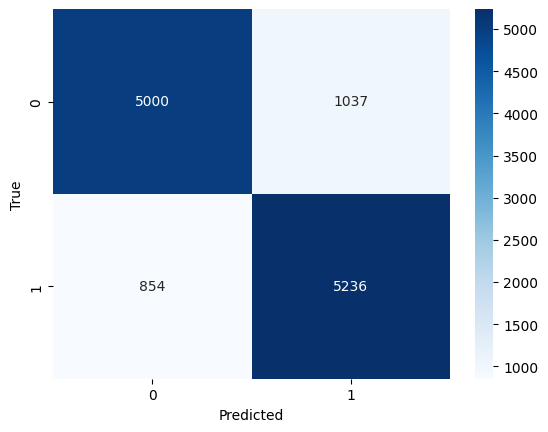

In [116]:
#Evalúo el Arbol con los mejores hiperparámetros

#Hago predicción sobre el set de evaluacion
y_pred= arbol.predict(x_test)

#Arbol Reporte y Matriz de Confusion
#print(classification_report(y_test,y_pred))
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary'))) #binary considera la clase positiva por defecto 1

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

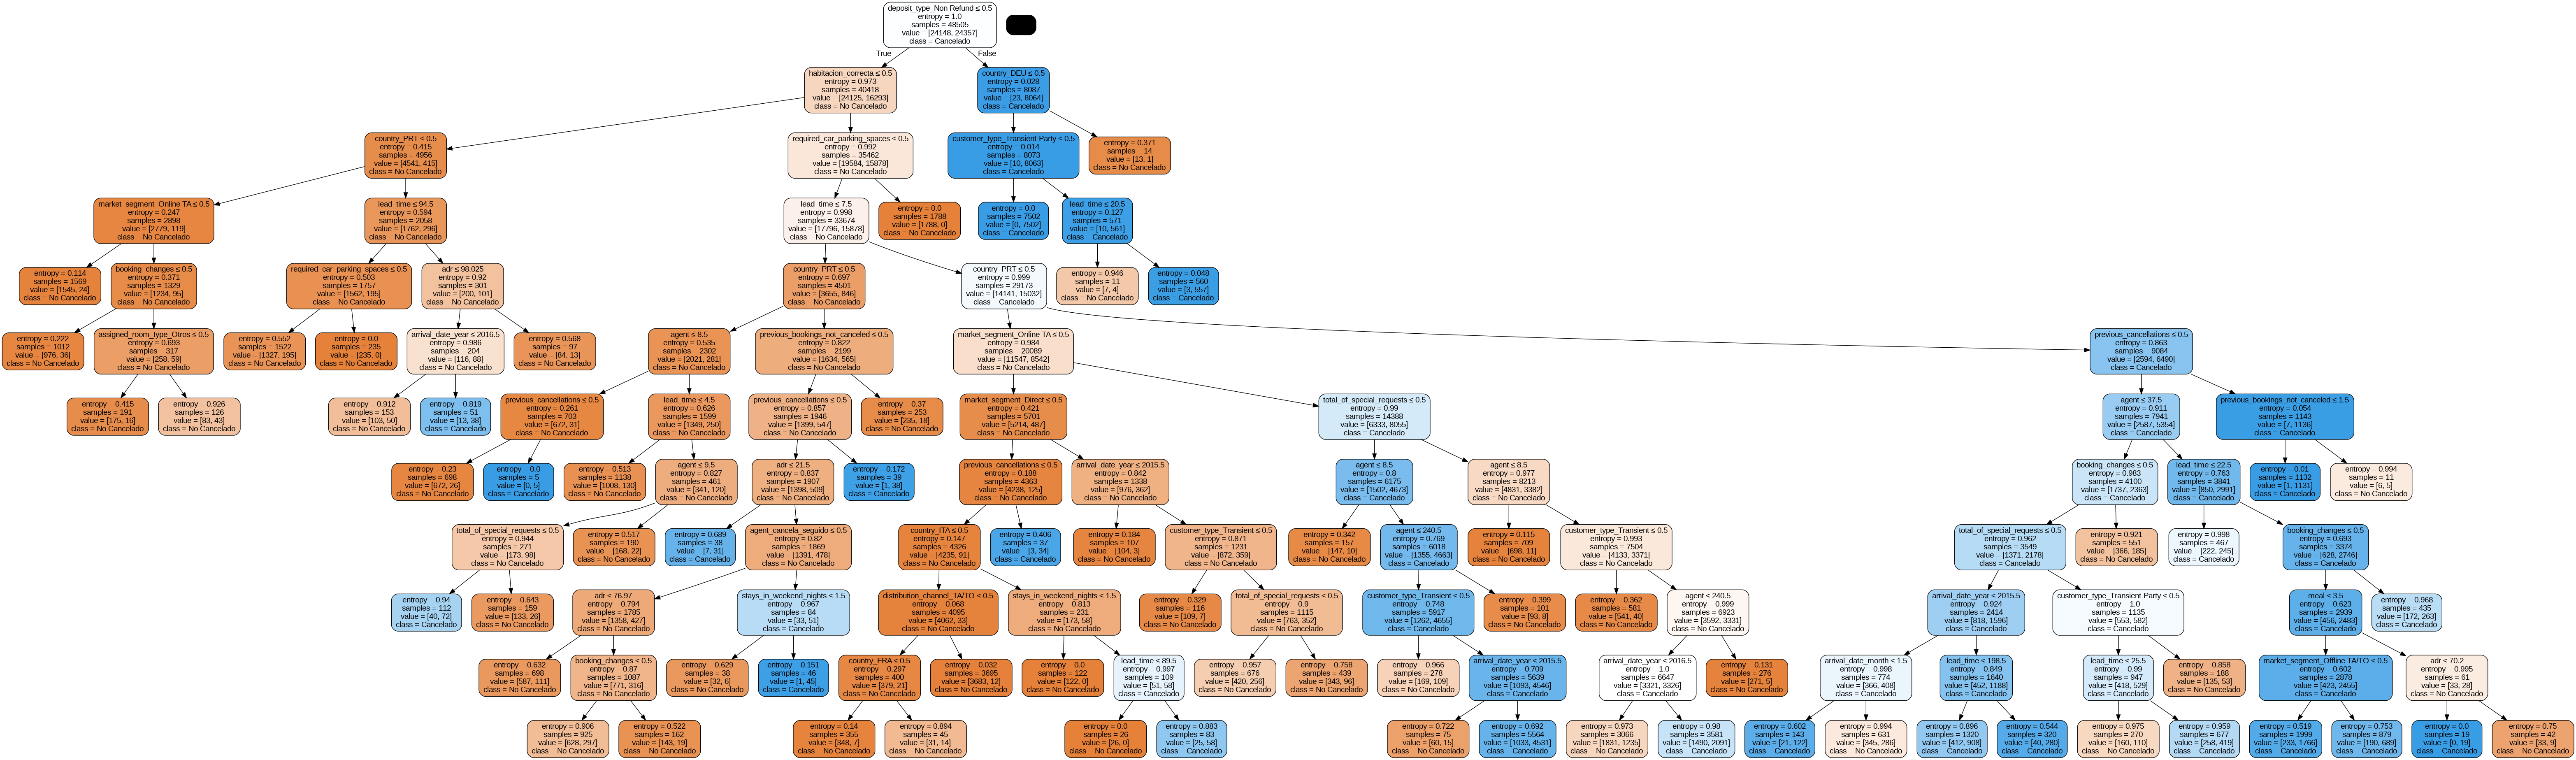

In [117]:
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=df_trabajo_x.columns.to_list(),
                class_names=['No Cancelado','Cancelado'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Arbol 6 - Grid search 

---



In [80]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 10

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.05,n), 
               'max_depth':list(range(1,12))}
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00555556, 0.01111111, 0.01666667, 0.02222222,
       0.02777778, 0.03333333, 0.03888889, 0.04444444, 0.05      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [83]:
#Mejores hiperparametros del arbol
print(gridcv.best_params_)
#Mejor métrica
print(gridcv.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 11}
0.8418098213355945


In [84]:
y_pred = gridcv.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8412632967757896


## Arbol 7 - Grid search


In [81]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.005,n), 
               'max_depth':list(range(1,14))}
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv2 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv2.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00035714, 0.00071429, 0.00107143, 0.00142857,
       0.00178571, 0.00214286, 0.0025    , 0.00285714, 0.00321429,
       0.00357143, 0.00392857, 0.00428571, 0.00464286, 0.005     ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [85]:
#Mejores hiperparametros del arbol
print(gridcv2.best_params_)
#Mejor métrica
print(gridcv2.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 13}
0.8504687905777744


In [86]:
y_pred = gridcv2.predict(x_test)
accuracy2 = accuracy_score(y_test, y_pred)
print(accuracy2)

0.8495918199059949


## Arbol 8 - Grid Search 

In [82]:
from sklearn.model_selection import GridSearchCV

#Cantidad de combinaciones que quiero porbar
n= 15

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               #'min_samples_leaf':list(range(1,10)),
               #'min_samples_split': list(range(2,20)),
               'ccp_alpha':np.linspace(0,0.01,n), 
               'max_depth':list(range(1,12))
               }
                
#Cantidad de splits para el Cross Validation
folds= 10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.accuracy_score)

#GridSearch CV
gridcv3 = GridSearchCV(estimator=base_tree ,param_grid=params_grid,scoring=scorer_fn,cv=kfoldcv,return_train_score='True') 

gridcv3.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.        , 0.00071429, 0.00142857, 0.00214286, 0.00285714,
       0.00357143, 0.00428571, 0.005     , 0.00571429, 0.00642857,
       0.00714286, 0.00785714, 0.00857143, 0.00928571, 0.01      ]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             return_train_score='True', scoring=make_scorer(accuracy_score))

In [87]:
#Mejores hiperparametros del arbol
print(gridcv3.best_params_)
#Mejor métrica
print(gridcv3.best_score_)

{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 11}
0.8419747527877132


In [88]:
y_pred = gridcv3.predict(x_test)
accuracy3 = accuracy_score(y_test, y_pred)
print(accuracy3)

0.8415931392759957


## Submission

In [102]:
#AGent
pivot_table = pd.pivot_table(df_trabajo, index="agent", columns="is_canceled", values="id", aggfunc="count", fill_value=0) 
pivot_table.columns = ["No Cancelado", "Cancelado"]
pivot_table["Total"] = pivot_table["No Cancelado"] + pivot_table["Cancelado"]
pivot_table["Porcentaje de Cancelados"] = np.rint(pivot_table["Cancelado"]/pivot_table["Total"]*100)

agents = pivot_table[(pivot_table["Porcentaje de Cancelados"] > 65) & (pivot_table["Total"] > 100)].index.to_list()

df_test["agent_cancela_seguido"] = df_test["agent"].isin(agents)

#Habitacion correcta
df_test['habitacion_correcta'] = (df_test['reserved_room_type'] == df_test['assigned_room_type'])

#Estadia
stay_mapping = {
    0: "Reservas sin\nnoches",
    1: "Reservas entre\nsemana",
    2: "Reservas en fin\nde semana",
    3: "Reserva con\nambos casos"
}

df_test['estadia'] = (
    df_test['stays_in_weekend_nights'].apply(lambda x: 2 if x > 0 else 0) + 
    df_test['stays_in_week_nights'].apply(lambda x: 1 if x > 0 else 0)
)


df_test['estadia'] = df_test['estadia'].map(stay_mapping)

df_test['country'].fillna("Otros")

df_test.loc[df_test["assigned_room_type"].isin(["B", "C", "H","I","K","P","L"]), "assigned_room_type"] = "Otros"
df_test.loc[df_test["reserved_room_type"].isin(["B", "C", "H","I","K","P","L"]), "reserved_room_type"] = "Otros"

lista_paises = df_trabajo["country"].value_counts().index.to_list()
lista_paises.remove("Otros")

df_test.loc[~df_test["country"].isin(lista_paises), "country"] = "Otros"





### OHE

In [103]:
X_submission = pd.get_dummies(df_test, columns=['hotel','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type'], drop_first=True)

from sklearn.preprocessing import (
    LabelEncoder
)

le = LabelEncoder()
# Convertimos nulos a string 'nan', es decir un valor posible mas
for column in X_submission.columns:
    if X_submission[column].dtype == 'object':
        X_submission[column] = le.fit_transform(X_submission[column])

In [104]:

#X_submission.drop(['id','company','arrival_date_month','arrival_date_week_number','arrival_date_year',"arrival_date_day_of_month",'children','babies','meal','reservation_status_date'], axis='columns',inplace=True)
X_submission.drop(['id','company','reservation_status_date'], axis='columns',inplace=True)
X_submission.fillna(0, inplace=True)

y_pred = randomcv5.predict(X_submission)
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [105]:
df_submission = pd.DataFrame({'id': df_test['id'], 'is_canceled': y_pred})
df_submission.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [106]:
df_submission.to_csv('/content/drive/My Drive/OrgaDeDatosRodriguez/TP_1/Submission/inicial_submission14.csv', index=False)

## Analisis para conseguir el mejor arbol

El mejor arbol que pudimos obtener fue haciendo Grid Search con 5 folds y 20 combinaciones diferentes. Y para nosotros la mejor metrica para representar los arboles es f1_score ya que la misma toma en cuenta el "recall" y "accuracy" las demas metricas no se fijan en tantos datos como lo hace el f1.


Nos dimos cuenta que evaluando los diferentes modelos con folds entre 5 y 10 terminaban usando la misma cantidad de variables y practicamente las mismas en cada caso. Al usar mas folds no variaba tanto la diferencia.